# Projet 3: Conception d'une application au service de la santé publique

## Nettoyage de données

### Sommaire

- <a href="#C2">Importation et taux de remplissage de données</a>

- <a href="#C3">Suppression des variables non consistent</a>

- <a href="#C4">Suppression des variables redondantes et unitiles pour l'application</a>

- <a href="#C5">Suppression des individus (lignes) sans noms de produits</a>

- <a href="#C6">Suppression des individus (lignes) sans informations nitrutionnelles</a>

- <a href="#C7">Suppression des doublons</a>

- <a href="#C8">Suppression des valeurs négatifs</a>

- <a href="#C9">Suppression des valeurs aberrantes</a>

- <a href="#C15">Suppression des colonnes nutriscores</a>

- <a href="#C16">Suppression des pays peu présentés</a>

- <a href="#C10">Remplissage des valeurs manquantes</a>

    * <a href="#C11">Remplissage des valeurs manquantes qualitatif par "unknown"</a>
    
    * <a href="#C12">Remplissage des valeurs manquantes quantitatif par la moyenne</a>
    
    * <a href="#C13">Remplissage des valeurs manquantes quantitatif par la méthode KNNImputer</a>
    
- <a href="#C14">Exportation jeu de données propres</a>

## <a name="C2">Importation et taux de remplissage</a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

Le jeu de données Open Food Facts est disponible sous deux versions:

> fr.openfoodfacts.org.products.csv - 847 MB

> en.openfoodfacts.org.products.csv - 5.3 GB
        
        
le choix était pas évident de savoir avec quelle version faut travailler, j'ai finis à adopter le fichier le plus volumineux.

</div>

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from collections import Counter
from wordcloud import WordCloud

In [3]:
pd.options.display.max_rows=190
pd.options.display.max_columns=190

In [4]:
chunksize = 100000

df_list = []

for df in pd.read_csv('en.openfoodfacts.org.products.csv', sep='\\t',encoding='utf8', chunksize=chunksize, engine='python'):
    df_list.append(df)

datas = pd.concat(df_list)

In [5]:
datas.shape

(2155361, 190)

In [6]:
datas.dtypes.value_counts()

float64    124
object      64
int64        2
dtype: int64

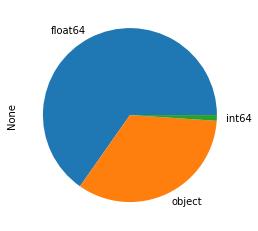

In [7]:
datas.dtypes.value_counts().plot.pie();

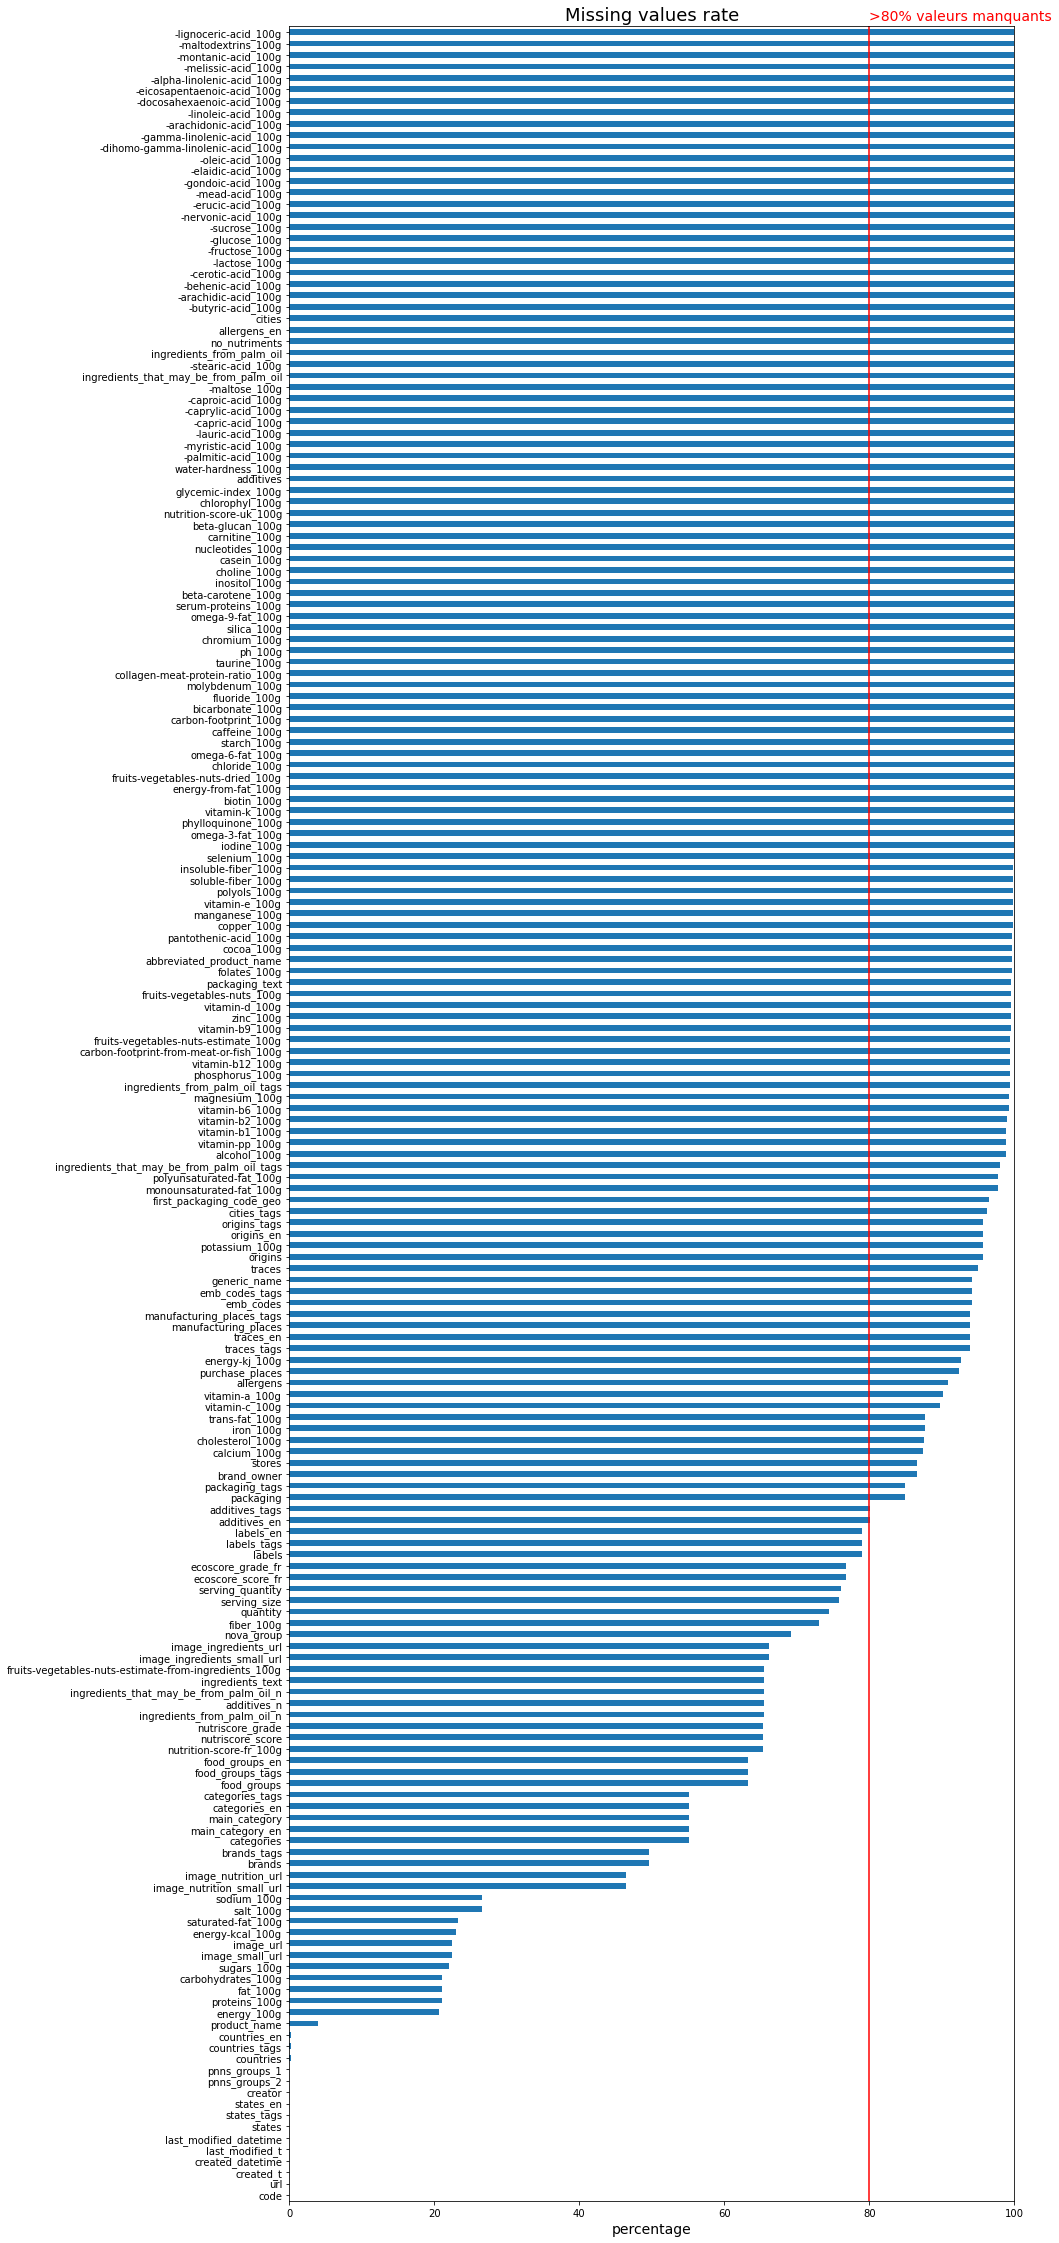

In [8]:
plt.figure(figsize=(13, 40))

(datas.isnull().mean(axis=0)*100).sort_values(ascending=True).plot.barh()

plt.axvline(80, c='red')

plt.text(80, 190, '>80% valeurs manquants', color='r',fontsize=14)

plt.xlim(xmax=100)
plt.title("Missing values rate",fontsize=18)
plt.xlabel("percentage",fontsize=14)

plt.show()

## <a name="C3">Suppression des variables non consistantes</a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

J'ai considéré que 20% est le seuil de remplissage minimum nécessaire, au dessous duquel les varaibles n'ont plus d'intérêt pour l'étude actuelle.
</div>

In [9]:
data1 = datas.dropna(axis=1,thresh=datas.shape[0]*0.2)

In [10]:
data1.shape

(2155361, 59)

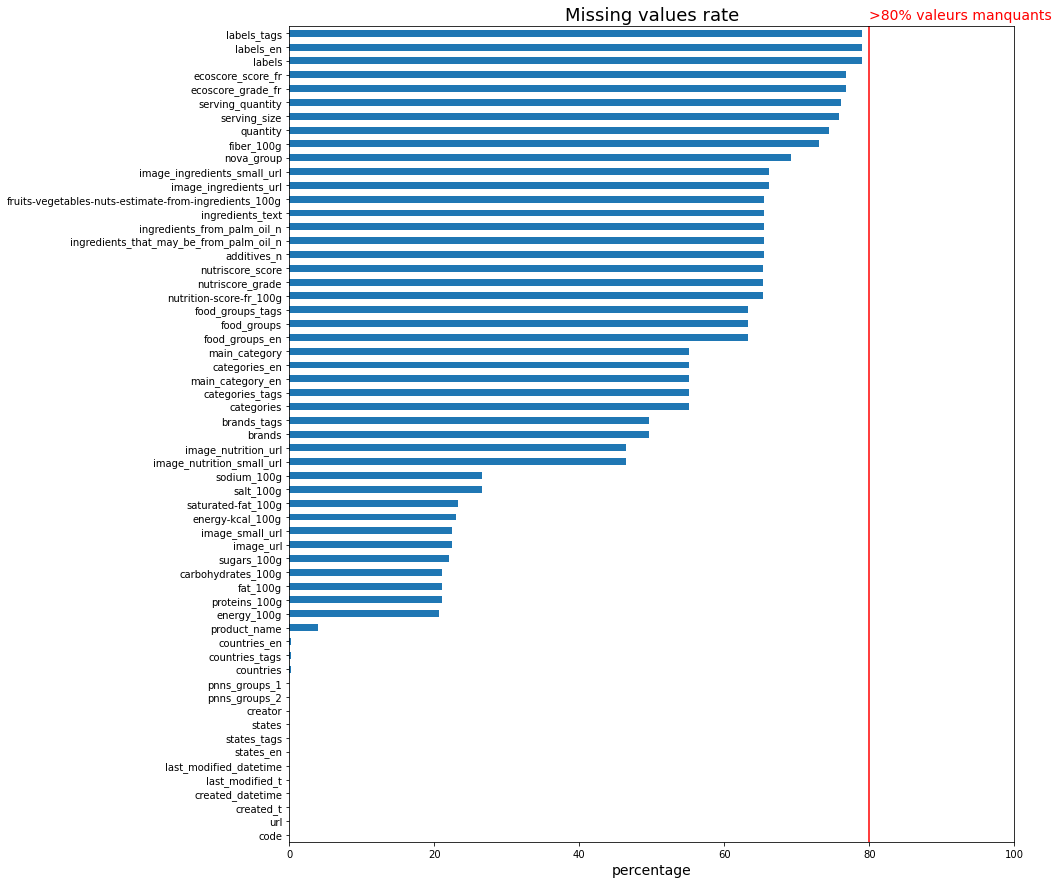

In [11]:
plt.figure(figsize=(13, 15))

(data1.isnull().mean(axis=0)*100).sort_values(ascending=True).plot.barh()

plt.axvline(80, c='red')
plt.text(80, 59, '>80% valeurs manquants', color='r',fontsize=14)

plt.xlim(xmax=100)
plt.title("Missing values rate",fontsize=18)
plt.xlabel("percentage",fontsize=14)

plt.show()

In [12]:
data1.head(1)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,quantity,brands,brands_tags,categories,categories_tags,categories_en,labels,labels_tags,labels_en,countries,countries_tags,countries_en,ingredients_text,serving_size,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",NaN,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## <a name="C4">Suppression des variables redondantes et unitiles pour l'application</a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

Je garde le code, la date de création et le nom de produit, les valeurs nutritionnelles "*_100g".

Pour les variables à différents formats, je garde le format "_tags", je supprime les url et je supprime les scores eco et nova (l'idée de l'application est que nutritionelle), la quantité et la volume. 
</div>

In [13]:
data1.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity',
       'brands', 'brands_tags', 'categories', 'categories_tags',
       'categories_en', 'labels', 'labels_tags', 'labels_en', 'countries',
       'countries_tags', 'countries_en', 'ingredients_text', 'serving_size',
       'serving_quantity', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'food_groups', 'food_groups_tags', 'food_groups_en', 'states',
       'states_tags', 'states_en', 'ecoscore_score_fr', 'ecoscore_grade_fr',
       'main_category', 'main_category_en', 'image_url', 'image_small_url',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url', 'energy-kcal_100g',
       'energy_100g', 'fat_100g', 'saturated-fat_100g'

In [14]:
data2 = data1.drop(['url', 'creator', 'created_t', 'categories_tags',
       'last_modified_t', 'last_modified_datetime', 'quantity',
       'brands', 'categories','states_tags',
       'categories_en', 'labels', 'labels_en', 'countries',
       'countries_en', 'serving_size','labels_tags','food_groups_tags',
       'serving_quantity','additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n','nova_group',
       'food_groups', 'food_groups_en', 'states','ingredients_text',
       'states_en', 'ecoscore_score_fr', 'ecoscore_grade_fr',
       'main_category_en', 'image_url', 'energy-kcal_100g',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url','nutrition-score-fr_100g'], axis=1)

In [15]:
data2.shape

(2155361, 21)

In [16]:
data2.head(1)

,code,created_datetime,product_name,brands_tags,countries_tags,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,main_category,image_small_url,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,2021-06-16T14:53:28Z,jeunes pousses,endives,en:france,NaN,NaN,unknown,unknown,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### je renome le veriable 'fruits-vegetables-nuts-estimate-from-ingredients_100g' par 'fruits_vegetables_100g'

In [17]:
data2 = data2.rename(columns={"fruits-vegetables-nuts-estimate-from-ingredients_100g":"fruits_vegetables_100g"})

## <a name="C5">Suppression des individus (lignes) sans nom du produits </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">
nous passons de 2 155 361 lignes à 2 070 618 lignes
</div>

In [18]:
data2.drop(data2[data2['product_name'].isna()].index, axis=0, inplace=True)

<AxesSubplot:>

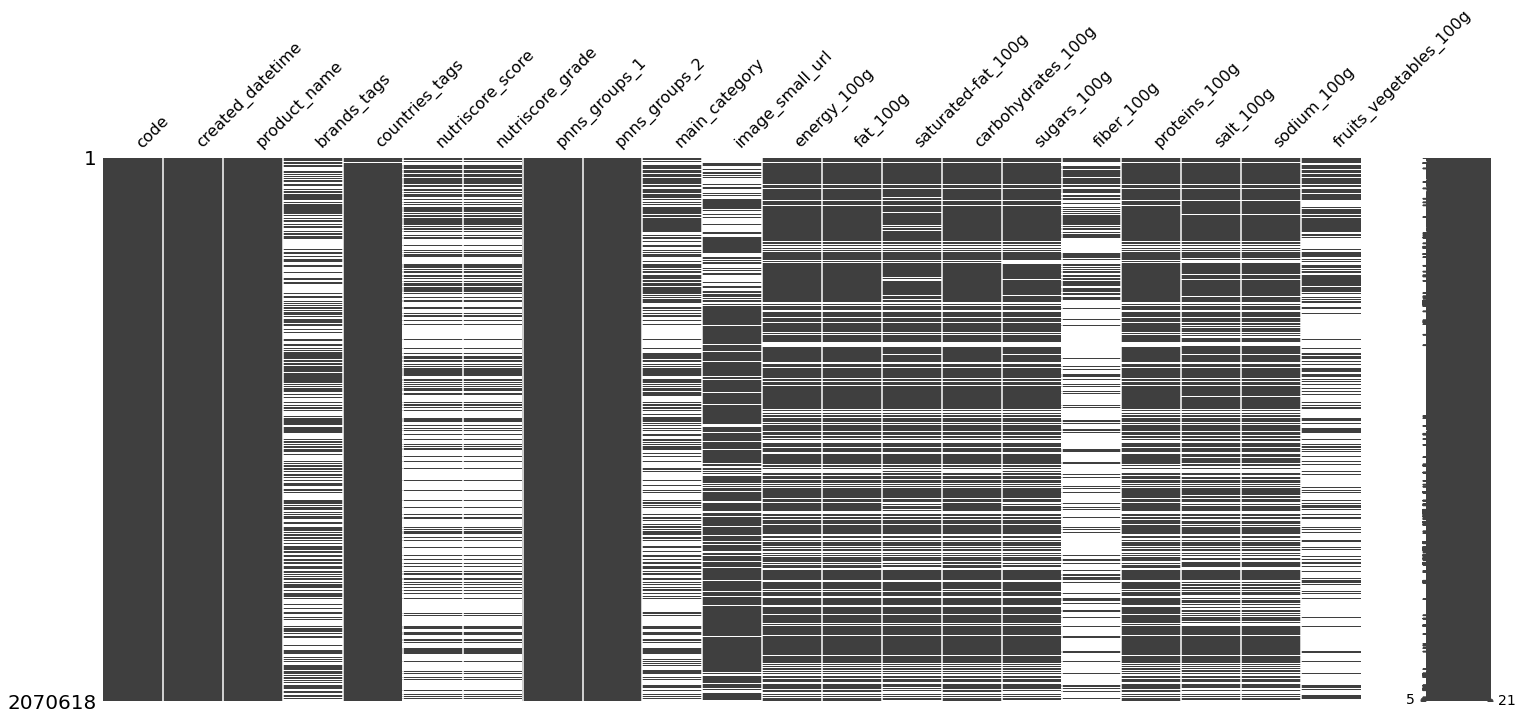

In [19]:
msn.matrix(data2)

## <a name="C6">Suppression des individus (lignes) sans informations nitrutionnelles </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

Pour l'application, nous aurons besoin des informations sur les nutriments des produits. Ces données sont suffixées avec _100g. Nous allons donc conserver les lignes pour lesquelles au moins une de ces variables est complétée :
    
nous passons de 2 070 618 lignes à 1 803 090 lignes  --> data3
</div>

In [20]:

def search_componant(df, suffix='_100g'):
    componant = []
    for col in df.columns:
        if '_100g' in col: componant.append(col)
    df_subset_columns = df[componant]
    return df_subset_columns

In [21]:
data_nutrition = search_componant(data2,'_100g')
data_nutrition.head()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.1,0.04,0.0
2,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.4,0.56,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,685.8,1.9,1.00,NaN,NaN,NaN,15.3,1.1,0.44,NaN


In [22]:
print('il y a {} lignes avec aucune information nutritionelle'.format(data_nutrition.isna().all(axis=1).sum()))

il y a 267528 lignes avec aucune information nutritionelle


In [23]:
data2 = data2[data_nutrition.notna().any(axis=1)]

<AxesSubplot:>

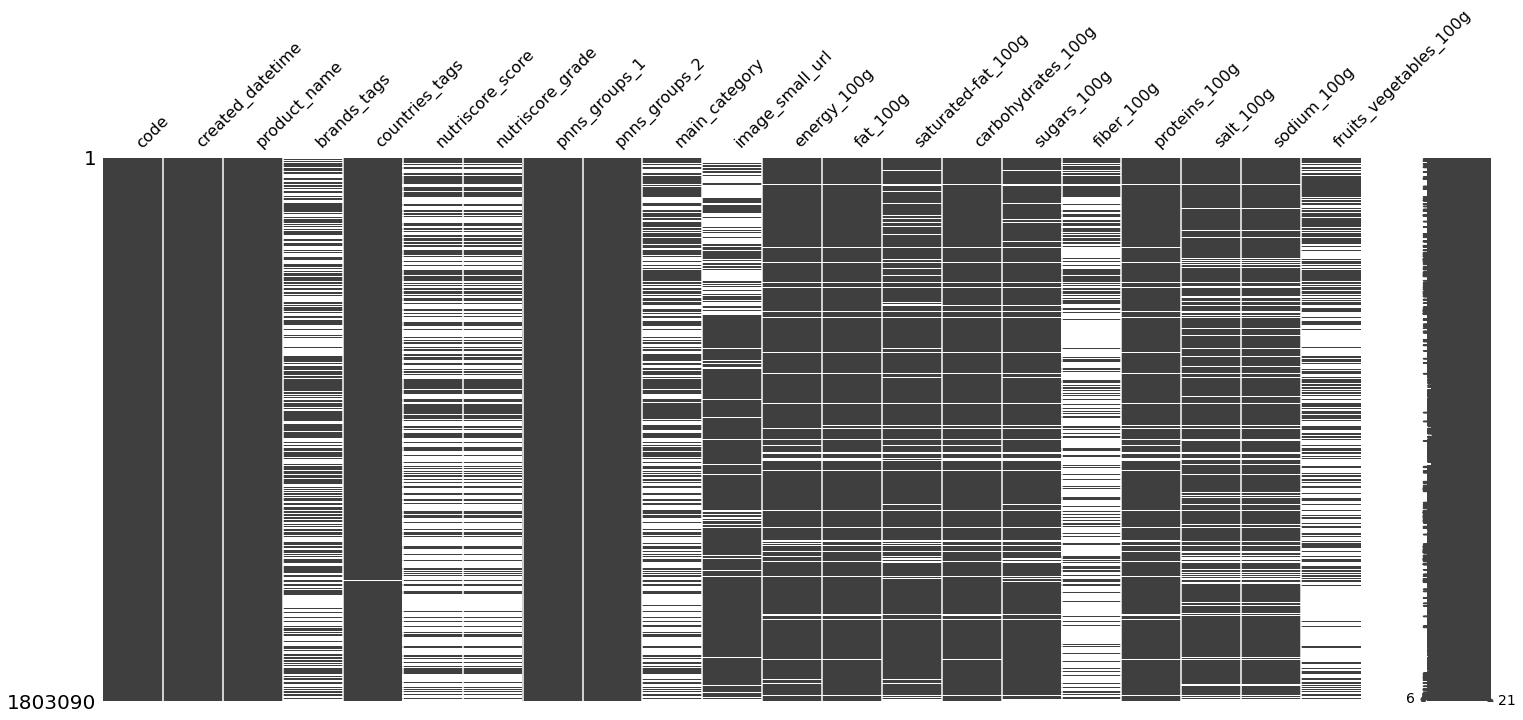

In [24]:
msn.matrix(data2)

## <a name="C7">Suppression des doublons </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

je supprime les doublons selon le code
</div>

In [25]:
data2 = data2.drop_duplicates('code', keep='last')
data2.shape

(1803076, 21)

## <a name="C8">Suppression des valeurs négatifs </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

Je supprime les valeur négatifs des colonnes des variables nutritionnelles

</div>

In [26]:
data2.describe()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_100g
count,743488.000000,1.700071e+06,1.691526e+06,1.646408e+06,1.691093e+06,1.672065e+06,5.770510e+05,1.692898e+06,1.574942e+06,1.574939e+06,736536.000000
mean,9.116486,3.080891e+23,5.022002e+14,5.153549e+23,5.912276e+04,5.672952e+08,1.700591e+41,5.904366e+04,6.345455e+04,2.538187e+04,8.619260
std,8.849997,4.017075e+26,6.523864e+17,6.612645e+26,7.684648e+07,6.606899e+11,1.291834e+44,7.680550e+07,7.962977e+07,3.185194e+07,36.381079
min,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-2.000000e+01,-5.000000e+02,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,4.180000e+02,8.000000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000e+00,1.300000e+00,8.000000e-02,3.200000e-02,0.000000
50%,10.000000,1.079000e+03,7.000000e+00,1.800000e+00,1.530000e+01,3.570000e+00,1.600000e+00,6.000000e+00,5.800000e-01,2.320000e-01,0.000000
75%,16.000000,1.674000e+03,2.125000e+01,7.080000e+00,5.300000e+01,1.750000e+01,3.600000e+00,1.250000e+01,1.400000e+00,5.600000e-01,0.560000
max,40.000000,5.237734e+29,8.484846e+20,8.484845e+29,9.993273e+10,8.484545e+14,9.813275e+46,9.993273e+10,9.993273e+10,3.997309e+10,13461.000000


In [27]:
def supp_neg(df, list_columns): 
    for col in list_columns:
        for i in df[df[col].fillna(0)<0].index:
            df.loc[i,col] = np.nan            

In [28]:
supp_neg(data2, data_nutrition.columns)
data2.describe()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_100g
count,743488.000000,1.700071e+06,1.691526e+06,1.646408e+06,1.691092e+06,1.672061e+06,5.770380e+05,1.692896e+06,1.574942e+06,1.574939e+06,736536.000000
mean,9.116486,3.080891e+23,5.022002e+14,5.153549e+23,5.912280e+04,5.672966e+08,1.700629e+41,5.904373e+04,6.345455e+04,2.538187e+04,8.619260
std,8.849997,4.017075e+26,6.523864e+17,6.612645e+26,7.684651e+07,6.606907e+11,1.291849e+44,7.680555e+07,7.962977e+07,3.185194e+07,36.381079
min,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,4.180000e+02,8.000000e-01,1.000000e-01,3.500000e+00,6.000000e-01,0.000000e+00,1.300000e+00,8.000000e-02,3.200000e-02,0.000000
50%,10.000000,1.079000e+03,7.000000e+00,1.800000e+00,1.530000e+01,3.570000e+00,1.600000e+00,6.000000e+00,5.800000e-01,2.320000e-01,0.000000
75%,16.000000,1.674000e+03,2.125000e+01,7.080000e+00,5.300000e+01,1.750000e+01,3.600000e+00,1.250000e+01,1.400000e+00,5.600000e-01,0.560000
max,40.000000,5.237734e+29,8.484846e+20,8.484845e+29,9.993273e+10,8.484545e+14,9.813275e+46,9.993273e+10,9.993273e+10,3.997309e+10,13461.000000


## <a name="C9">Suppression des valeurs aberrantes </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

J'utilise la méthode de quantile pour supprimer les valeurs aberrantes

nous passons à 1 796 728 lignes
</div>

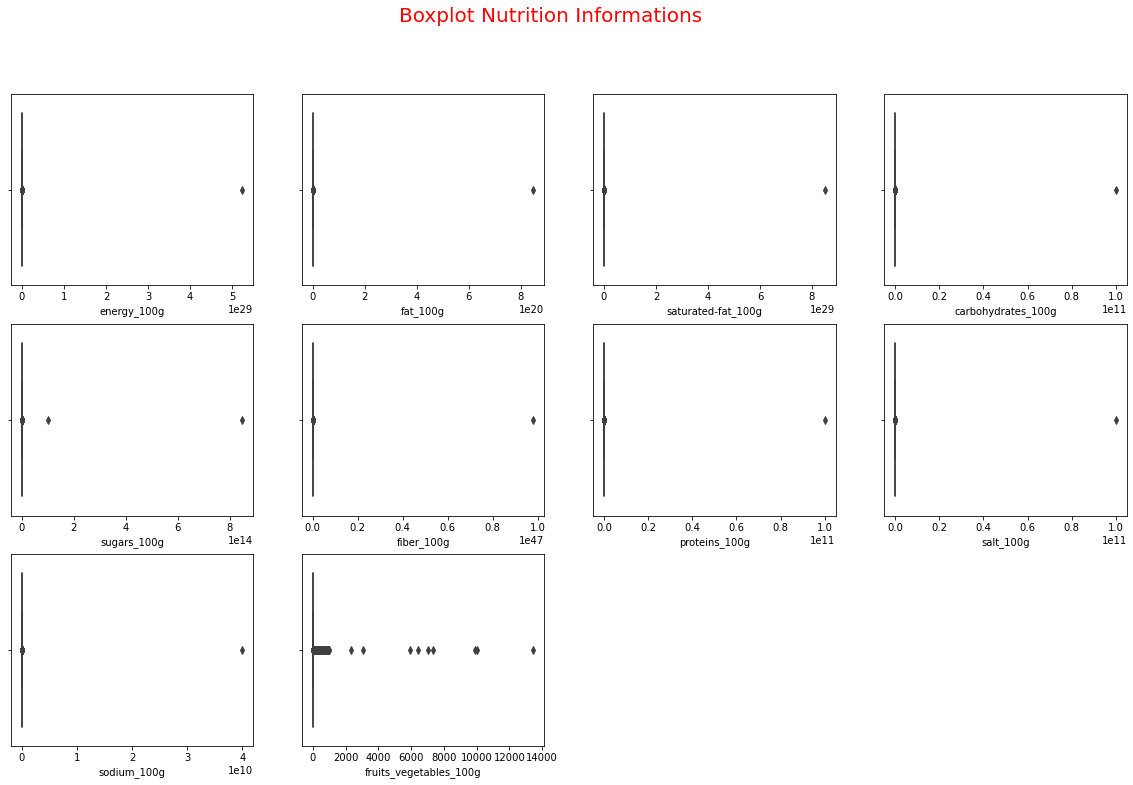

In [29]:
n=0

plt.figure(figsize=(20, 12))

for col in data_nutrition.columns:
    n+=1
    plt.subplot(3,4,n)
    sns.boxplot(x=data2[col], orient="h")
    #plt.title(col)

plt.suptitle('Boxplot Nutrition Informations', fontsize=20, c='r')        
      
plt.show();

In [30]:
quantile=0.0008 # cette valeur est calibrée pour avoir valeur max de 100g en sucre et sel
qmax=data2.quantile(q=1-quantile, interpolation='higher')
qmin=data2.fillna(0).quantile(q=quantile, interpolation='lower')
#print(qmax,qmin, (1-quantile)*100)

for col in data_nutrition.columns:
    #print(col)
    valmax=qmax[col]
    valmin=qmin[col]
    #print((df3[col]>qmax[col]).value_counts())
    #print(valmax,valmin)
    data2=data2[data2[col].fillna(0)<=valmax]
    data2=data2[data2[col].fillna(0)>=valmin]
    

In [31]:
data2.describe()

,nutriscore_score,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_100g
count,741480.000000,1.693957e+06,1.685544e+06,1.640871e+06,1.685142e+06,1.666596e+06,574291.000000,1.686910e+06,1.569946e+06,1.569943e+06,734395.000000
mean,9.105915,1.137201e+03,1.363324e+01,5.005205e+00,2.809385e+01,1.303515e+01,3.073599,8.648951e+00,1.356190e+00,5.424850e-01,8.335742
std,8.843661,8.199644e+02,1.753631e+01,7.442587e+00,2.792161e+01,1.937087e+01,4.961085,9.751225e+00,4.657144e+00,1.862902e+00,21.855257
min,-15.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,4.180000e+02,8.000000e-01,1.000000e-01,3.530000e+00,6.000000e-01,0.000000,1.300000e+00,8.000000e-02,3.200000e-02,0.000000
50%,10.000000,1.079000e+03,7.000000e+00,1.800000e+00,1.538000e+01,3.570000e+00,1.600000,6.000000e+00,5.800000e-01,2.320000e-01,0.000000
75%,16.000000,1.674000e+03,2.120000e+01,7.040000e+00,5.300000e+01,1.750000e+01,3.600000,1.250000e+01,1.400000e+00,5.600000e-01,0.500000
max,40.000000,6.150000e+03,1.000000e+02,8.666667e+01,1.000000e+02,1.000000e+02,75.000000,8.636000e+01,1.000000e+02,4.000000e+01,137.000000


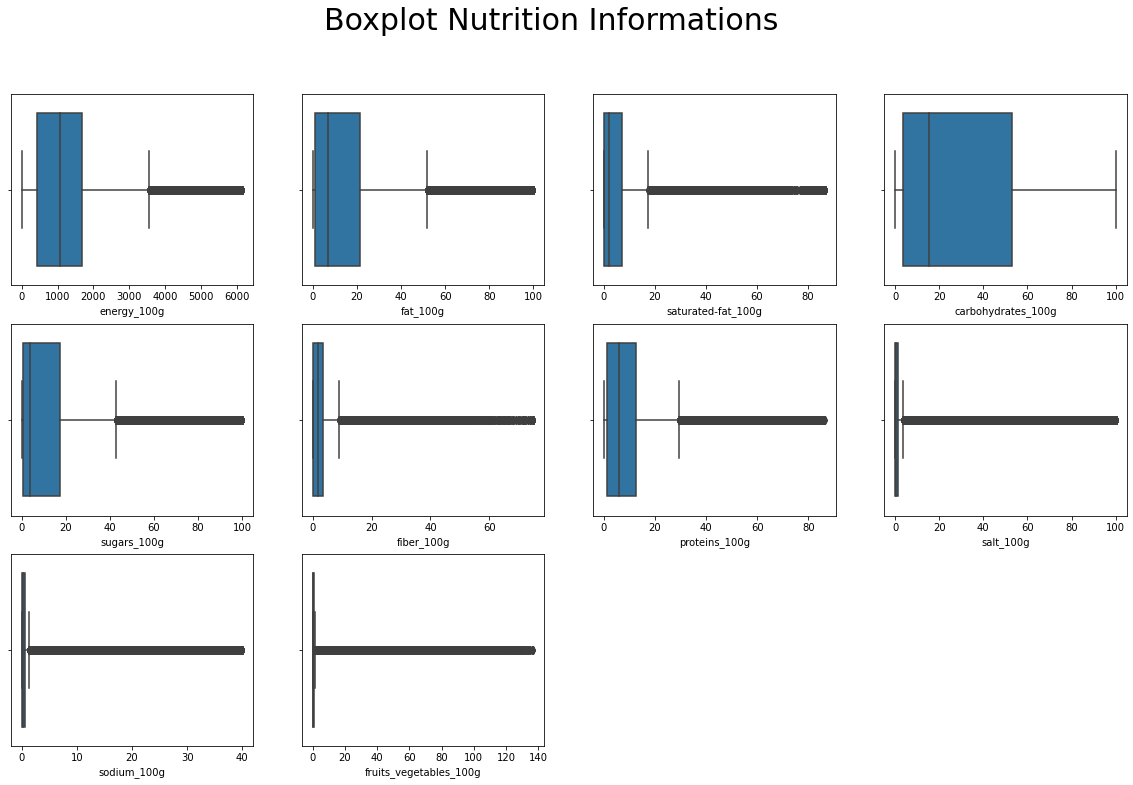

In [32]:
n=0

plt.figure(figsize=(20, 12))

for col in data_nutrition.columns:
    n+=1
    plt.subplot(3,4,n)
    sns.boxplot(x=data2[col], orient="h")
    #plt.title(col)

plt.suptitle('Boxplot Nutrition Informations', fontsize=30, fontweight=30)        
      
plt.show();

### Après ce premier nettoyage des valeurs abbérantes nous constatons que:
#### 1- le variable __'fruits-vegetables-nuts-estimate-from-ingredients_100g'__ est supérieur à 100g. nous allons supprimer tous les individus ont plus de 100g
#### 2- les variables 'energy-kcal_100g' et	'energy_100g' ont des valeurs supérieur au densité d'énergie massique maximal (900kcal ou 3700kJ par 100g) de même on procède à la suppression de ces valeurs.

In [33]:
data2 = data2[data2['fruits_vegetables_100g'].fillna(0)<=100]

In [34]:
data2=data2[data2['energy_100g'].fillna(0)<=3700]

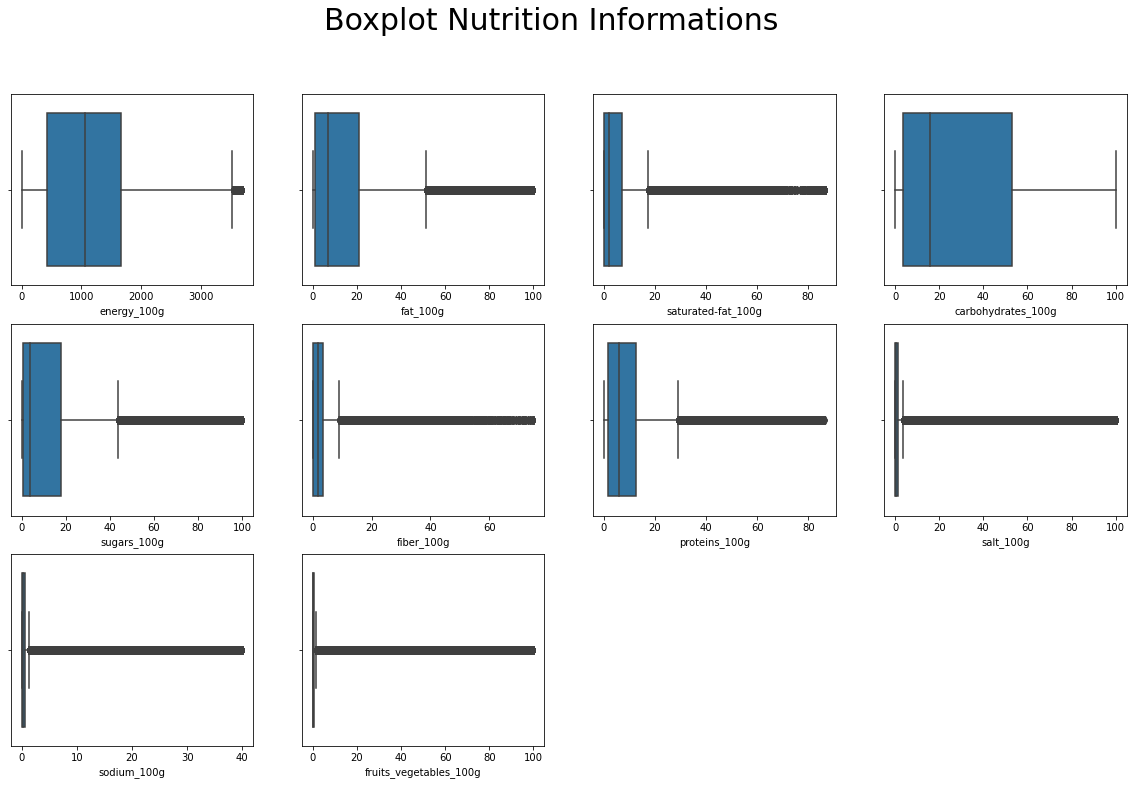

In [35]:
n=0

plt.figure(figsize=(20, 12))

for col in data_nutrition.columns:
    n+=1
    plt.subplot(3,4,n)
    sns.boxplot(x=data2[col], orient="h")
    #plt.title(col)

plt.suptitle('Boxplot Nutrition Informations', fontsize=30, fontweight=30)        
      
plt.show();

In [36]:
data2.shape

(1783451, 21)

<AxesSubplot:>

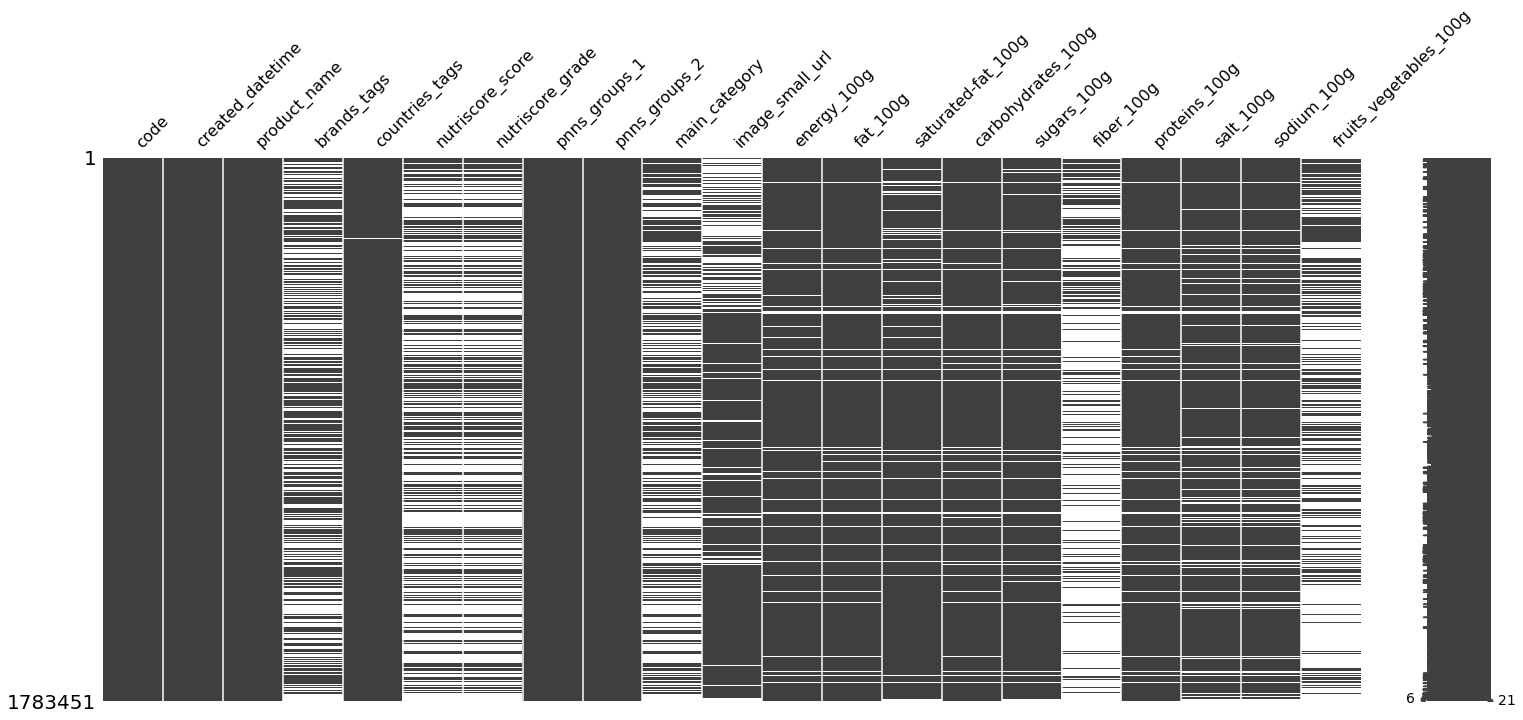

In [38]:
msn.matrix(data2)

In [39]:
data2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1783451 entries, 1 to 2155359
Data columns (total 21 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   code                    1783451 non-null  object 
 1   created_datetime        1783451 non-null  object 
 2   product_name            1783451 non-null  object 
 3   brands_tags             943590 non-null   object 
 4   countries_tags          1780076 non-null  object 
 5   nutriscore_score        735407 non-null   float64
 6   nutriscore_grade        735407 non-null   object 
 7   pnns_groups_1           1783451 non-null  object 
 8   pnns_groups_2           1783451 non-null  object 
 9   main_category           877352 non-null   object 
 10  image_small_url         1389154 non-null  object 
 11  energy_100g             1680623 non-null  float64
 12  fat_100g                1672239 non-null  float64
 13  saturated-fat_100g      1627736 non-null  float64
 14  ca

## <a name="C15">Suppression des colonnes nutriscores </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">
J'ai décidé de supprimer les deux varaibles 'nutriscore_score' et 'nutriscore_grade'pour deux raisons:

> - 1 ce sont des calculs à partir de valeurs des autres nutriments il n y'a aucun sens de les estimés et je n'est pas réussi à trouver la formule pour les calculer. 

> - 2 ce sont de score générale qui classe de façon globale les produits au contraire de l'idée de l'application de ce projet, qui est spéciale pour un nutriment bien préscise par exemple, glucide, ou sel ou gras etc.
</div>

In [40]:
data2.drop(columns=['nutriscore_score','nutriscore_grade'], inplace=True)

In [41]:
data2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1783451 entries, 1 to 2155359
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   code                    1783451 non-null  object 
 1   created_datetime        1783451 non-null  object 
 2   product_name            1783451 non-null  object 
 3   brands_tags             943590 non-null   object 
 4   countries_tags          1780076 non-null  object 
 5   pnns_groups_1           1783451 non-null  object 
 6   pnns_groups_2           1783451 non-null  object 
 7   main_category           877352 non-null   object 
 8   image_small_url         1389154 non-null  object 
 9   energy_100g             1680623 non-null  float64
 10  fat_100g                1672239 non-null  float64
 11  saturated-fat_100g      1627736 non-null  float64
 12  carbohydrates_100g      1671929 non-null  float64
 13  sugars_100g             1653629 non-null  float64
 14  fi

## <a name="C16">Suppression des pays peu présentés </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">

</div>

In [65]:
def most_common_word(data, label, sep=",",n=10):
    words=[]
    for string in data[label]:
        listwords=string.split(sep)
        for w in listwords:
            if w!=" " and w!="unknown":
                if w.startswith('en:') or w.startswith('fr:'):
                    w=w[3:]
                words.append(w)
    count=Counter(words)
    for word in count.most_common(n):
        print(word)

In [68]:
data2.drop(data2[data2['countries_tags'].isna()].index, axis=0, inplace=True)

In [71]:
most_common_word(data2, label='countries_tags', sep=',', n=30)

('france', 702456)
('united-states', 399070)
('spain', 201831)
('italy', 124864)
('germany', 94107)
('switzerland', 61393)
('belgium', 58072)
('united-kingdom', 48238)
('canada', 40574)
('ireland', 15974)
('australia', 15333)
('russia', 7915)
('netherlands', 7886)
('austria', 5894)
('mexico', 5834)
('poland', 5315)
('portugal', 4625)
('luxembourg', 4451)
('sweden', 4079)
('morocco', 3696)
('romania', 2960)
('argentina', 2808)
('reunion', 2711)
('thailand', 2559)
('norway', 2558)
('finland', 2555)
('czech-republic', 2531)
('hungary', 2292)
('bulgaria', 1898)
('algeria', 1781)


## Nous gardons que les dix premiers pays

In [72]:
data2 = data2.drop(data2[(data2['countries_tags']!='en:france') & (data2['countries_tags']!='en:united-states') 
            & (data2['countries_tags']!='en:spain') & (data2['countries_tags']!='en:italy') 
            & (data2['countries_tags']!='en:germany') & (data2['countries_tags']!='en:switzerland') 
            & (data2['countries_tags']!='en:united-kingdom') & (data2['countries_tags']!='en:canada')
            & (data2['countries_tags']!='en:ireland')].index, axis=0) 

In [73]:
data2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544742 entries, 1 to 2155359
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   code                    1544742 non-null  object 
 1   created_datetime        1544742 non-null  object 
 2   product_name            1544742 non-null  object 
 3   brands_tags             1544742 non-null  object 
 4   countries_tags          1544742 non-null  object 
 5   pnns_groups_1           1544742 non-null  object 
 6   pnns_groups_2           1544742 non-null  object 
 7   main_category           1544742 non-null  object 
 8   image_small_url         1544742 non-null  object 
 9   energy_100g             1466555 non-null  float64
 10  fat_100g                1459450 non-null  float64
 11  saturated-fat_100g      1427820 non-null  float64
 12  carbohydrates_100g      1458649 non-null  float64
 13  sugars_100g             1451007 non-null  float64
 14  fi

## <a name="C10">Remplissage des valeurs manquantes </a>

<div class="alert alert-block alert-info" style="margin-top: 20px">
Après cette première phase de nettoyage nous pouvons classé le jeu de données en 4 classes pour chaqune une méthode de remplissage différente:

> 1-les variables qualitatifs s(object) nous pouvons rien faire, nous remplissons les valeurs manquanyes par 'unknown'

> 2-les variables quanitatifs (float) peu renseignés 'fibre_100g' et 'fruits-vegetables-nuts-estimate-from-ingredients_100g' on va les remplasser par la moyenne de leur groupe pnns_groups_2 respectifs

> 3-les restes des variables quanitatifs (à part les nutrition scores) avec relativement peu des valeurs manquantes, on va utiliser la méthode KNNImputer.



### <a name="C11">Remplissage des valeurs manquantes par "unknown" </a>

In [74]:
data2.brands_tags.fillna(value='unknown', inplace=True)

In [75]:
data2.main_category.fillna(value='unknown', inplace=True)

In [76]:
data2.image_small_url.fillna(value='unknown', inplace=True)

In [77]:
data2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544742 entries, 1 to 2155359
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   code                    1544742 non-null  object 
 1   created_datetime        1544742 non-null  object 
 2   product_name            1544742 non-null  object 
 3   brands_tags             1544742 non-null  object 
 4   countries_tags          1544742 non-null  object 
 5   pnns_groups_1           1544742 non-null  object 
 6   pnns_groups_2           1544742 non-null  object 
 7   main_category           1544742 non-null  object 
 8   image_small_url         1544742 non-null  object 
 9   energy_100g             1466555 non-null  float64
 10  fat_100g                1459450 non-null  float64
 11  saturated-fat_100g      1427820 non-null  float64
 12  carbohydrates_100g      1458649 non-null  float64
 13  sugars_100g             1451007 non-null  float64
 14  fi

### <a name="C12">Remplissage des valeurs manquantes par la moyenne </a>

In [81]:
# On remplit les variables 'fiber_100g' et 'fruits-vegetables-nuts-estimate-from-ingredients_100g'avec la moyenne du main_category
for col in ['fruits_vegetables_100g','fiber_100g']:
    data2[col] = data2.groupby('pnns_groups_2')[col].transform(lambda x: x.fillna(x.mean()))

In [82]:
data2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544742 entries, 1 to 2155359
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   code                    1544742 non-null  object 
 1   created_datetime        1544742 non-null  object 
 2   product_name            1544742 non-null  object 
 3   brands_tags             1544742 non-null  object 
 4   countries_tags          1544742 non-null  object 
 5   pnns_groups_1           1544742 non-null  object 
 6   pnns_groups_2           1544742 non-null  object 
 7   main_category           1544742 non-null  object 
 8   image_small_url         1544742 non-null  object 
 9   energy_100g             1466555 non-null  float64
 10  fat_100g                1459450 non-null  float64
 11  saturated-fat_100g      1427820 non-null  float64
 12  carbohydrates_100g      1458649 non-null  float64
 13  sugars_100g             1451007 non-null  float64
 14  fi

In [83]:
data2.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits_vegetables_100g
count,1.466555e+06,1.459450e+06,1.427820e+06,1.458649e+06,1.451007e+06,1.544742e+06,1.460725e+06,1.373028e+06,1.373026e+06,1.544742e+06
mean,1.117827e+03,1.327349e+01,4.971494e+00,2.819278e+01,1.314559e+01,2.979243e+00,8.804141e+00,1.366027e+00,5.464207e-01,7.561244e+00
std,7.743693e+02,1.650791e+01,7.332310e+00,2.796816e+01,1.950607e+01,3.165993e+00,9.813001e+00,4.610043e+00,1.844074e+00,1.567657e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.240000e+02,8.000000e-01,1.000000e-01,3.500000e+00,6.000000e-01,1.000000e+00,1.400000e+00,9.000000e-02,3.601541e-02,0.000000e+00
50%,1.075000e+03,7.000000e+00,1.800000e+00,1.580000e+01,3.570000e+00,3.506720e+00,6.100000e+00,6.000000e-01,2.400000e-01,5.831517e+00
75%,1.664000e+03,2.100000e+01,7.000000e+00,5.300000e+01,1.800000e+01,3.506720e+00,1.283000e+01,1.400000e+00,5.600000e-01,5.831517e+00
max,3.700000e+03,1.000000e+02,8.666667e+01,1.000000e+02,1.000000e+02,7.500000e+01,8.636000e+01,1.000000e+02,4.000000e+01,1.000000e+02


### <a name="C13">Remplissage des valeurs manquantes par la méthode KNNImputer </a>

In [85]:
dataknn = data2[['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g',
                 'sugars_100g','proteins_100g','salt_100g','sodium_100g']]

In [86]:
imputer=KNNImputer()
data_imputed=imputer.fit_transform(dataknn)

In [88]:
data_imputed = pd.DataFrame(data_imputed)
data_imputed.set_axis(['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g',
                 'sugars_100g','proteins_100g','salt_100g','sodium_100g'], axis= 'columns', inplace=True)
data_imputed.set_axis(data2.index, axis= 'index', inplace=True)
data_imputed.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
count,1.544742e+06,1.544742e+06,1.544742e+06,1.544742e+06,1.544742e+06,1.544742e+06,1.544742e+06,1.544742e+06
mean,1.102027e+03,1.321143e+01,4.906224e+00,2.764413e+01,1.315911e+01,8.770140e+00,1.417414e+00,5.692815e-01
std,7.645298e+02,1.611804e+01,7.144113e+00,2.743360e+01,1.905907e+01,9.570980e+00,4.703166e+00,1.881295e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.180000e+02,9.000000e-01,1.000000e-01,3.700000e+00,6.000000e-01,1.600000e+00,8.000000e-02,3.200000e-02
50%,1.091000e+03,7.600000e+00,1.900000e+00,1.600000e+01,3.810000e+00,6.500000e+00,6.200000e-01,2.480000e-01
75%,1.640000e+03,2.010000e+01,6.896552e+00,5.100000e+01,1.800000e+01,1.200000e+01,1.392500e+00,5.600000e-01
max,3.700000e+03,1.000000e+02,8.666667e+01,1.000000e+02,1.000000e+02,8.636000e+01,1.000000e+02,4.000000e+01


In [89]:
data2.drop(['energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g',
                 'sugars_100g','proteins_100g','salt_100g','sodium_100g'], axis=1, inplace=True)

In [90]:
data2 = data2.join(data_imputed)
data2.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1544742 entries, 1 to 2155359
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   code                    1544742 non-null  object 
 1   created_datetime        1544742 non-null  object 
 2   product_name            1544742 non-null  object 
 3   brands_tags             1544742 non-null  object 
 4   countries_tags          1544742 non-null  object 
 5   pnns_groups_1           1544742 non-null  object 
 6   pnns_groups_2           1544742 non-null  object 
 7   main_category           1544742 non-null  object 
 8   image_small_url         1544742 non-null  object 
 9   fiber_100g              1544742 non-null  float64
 10  fruits_vegetables_100g  1544742 non-null  float64
 11  energy_100g             1544742 non-null  float64
 12  fat_100g                1544742 non-null  float64
 13  saturated-fat_100g      1544742 non-null  float64
 14  ca

### <a name="C14">Exportation du jeu de données propres </a>

In [91]:
data2.to_csv('en_openfoodfacts_org_products_clean.csv')

# Fin 